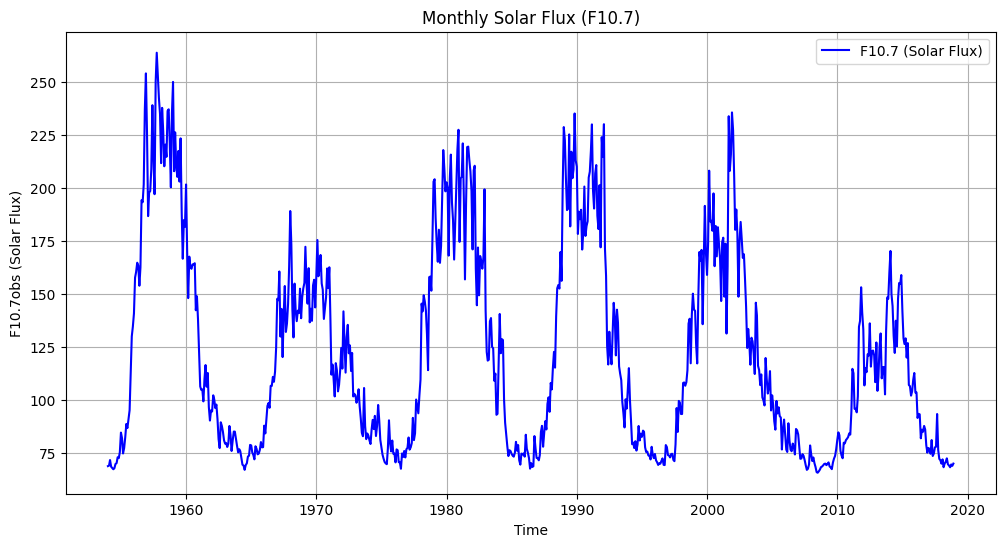

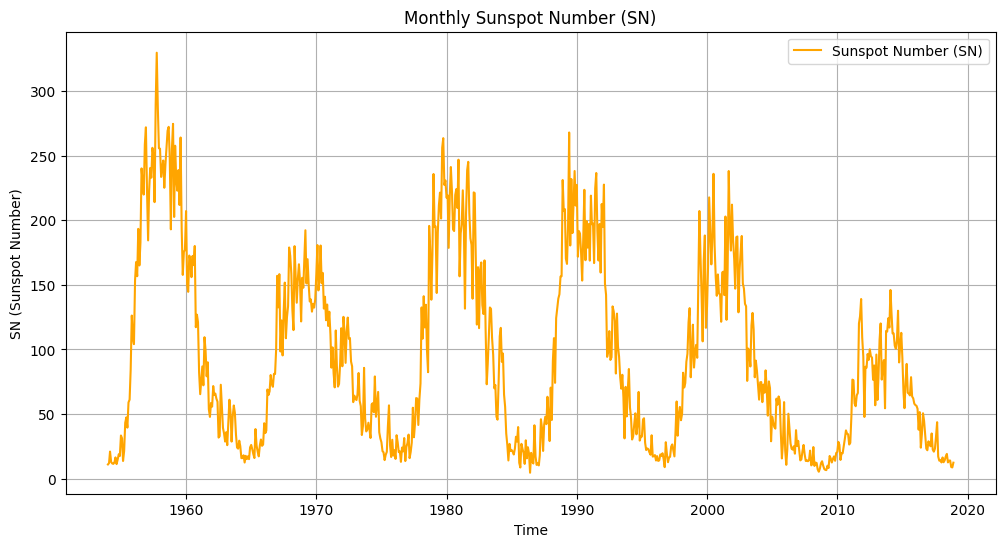

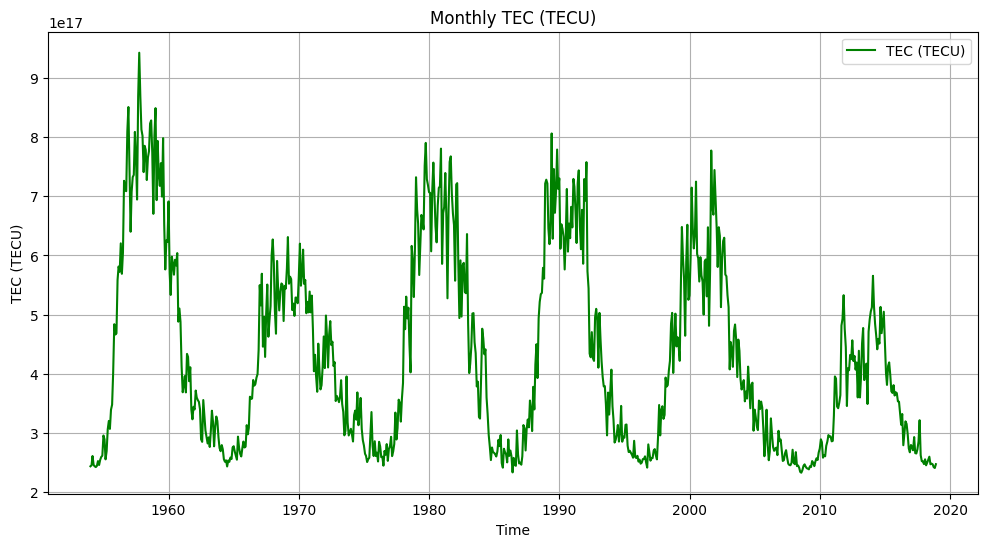

TEC calculation and preprocessing completed. Results saved to 'data.csv'.


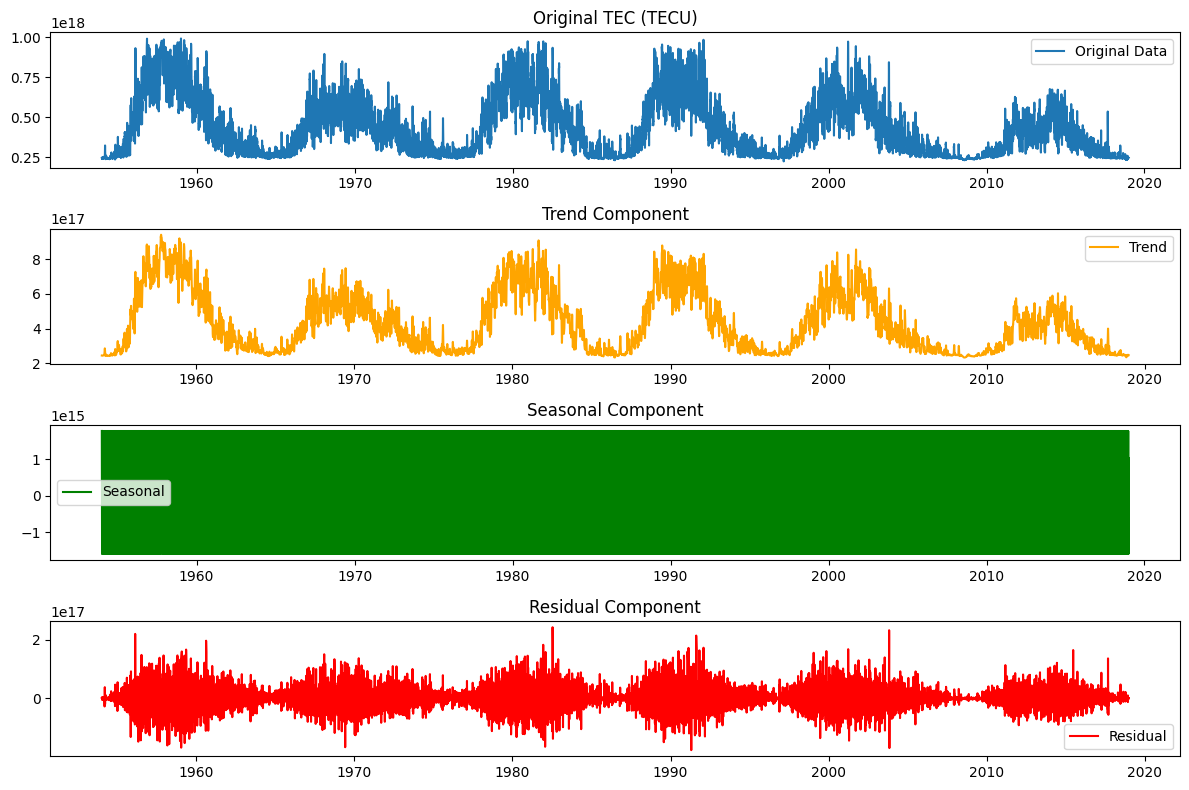

Dataset preparation completed. Saved as 'prepared_tec_data.csv'.


In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to handle negative values and zeros by replacing them with NaN
def handle_invalid_values(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)
    return df

# Function to compute peak electron density (Nm)
def compute_nm(F107, SN, Kp, C0=1e12, C1=1e10, C2=1e10, C3=-1e9):
    return C0 + C1 * F107 + C2 * SN + C3 * Kp

# Chapman function to model electron density
def chapman_function(h, Hm, Nm, H):
    z = (h - Hm) / H
    return Nm * np.exp(1 - z - np.exp(-z))

# Function to compute TEC by integrating the Chapman function
def compute_tec(Nm, Hm=350, H=50, h1=90, h2=1000):
    tec, _ = quad(chapman_function, h1, h2, args=(Hm, Nm, H))
    scaling_factor = 1e3
    return tec * scaling_factor

# Load dataset
file_path = "updated_tec_data.csv"
df = pd.read_csv(file_path)

# Handle invalid values
df = handle_invalid_values(df, ['F10.7obs', 'SN'])
df['F10.7obs'] = df['F10.7obs'].interpolate(method='linear', limit_direction='both')
df['SN'] = df['SN'].interpolate(method='linear', limit_direction='both')

# Handle Missing or Negative Values in Kp (Kp1 to Kp8)
df['Kp_avg'] = df[['Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8']].mean(axis=1)

# Compute TEC for Each Row in the Dataset
tec_values = []
for _, row in df.iterrows():
    F107 = row['F10.7obs']
    SN = row['SN']
    Kp_avg = row['Kp_avg']
    Nm = compute_nm(F107, SN, Kp_avg)
    tec = compute_tec(Nm)
    tec_values.append(tec)

df['TEC (TECU)'] = tec_values

# Step 5: Monthly averages for visualization
df['Date'] = pd.to_datetime(df[['YYY', 'MM', 'DD']].astype(str).agg('-'.join, axis=1))
df['Month'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('Month')[['F10.7obs', 'SN', 'TEC (TECU)']].mean()

# Step 6: Plot trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg['F10.7obs'], label='F10.7 (Solar Flux)', color='blue')
plt.xlabel('Time')
plt.ylabel('F10.7obs (Solar Flux)')
plt.title('Monthly Solar Flux (F10.7)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg['SN'], label='Sunspot Number (SN)', color='orange')
plt.xlabel('Time')
plt.ylabel('SN (Sunspot Number)')
plt.title('Monthly Sunspot Number (SN)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg['TEC (TECU)'], label='TEC (TECU)', color='green')
plt.xlabel('Time')
plt.ylabel('TEC (TECU)')
plt.title('Monthly TEC (TECU)')
plt.legend()
plt.grid()
plt.show()

# Save the updated dataset with TEC values
df.to_csv("data.csv", index=False)
print("TEC calculation and preprocessing completed. Results saved to 'data.csv'.")

# Normalize and standardize the data
data = pd.read_csv("data.csv")
columns_to_scale = ['F10.7obs', 'SN', 'TEC (TECU)', 'Kp_avg', 'Ap']
minmax_scaler = MinMaxScaler()
data[columns_to_scale] = minmax_scaler.fit_transform(data[columns_to_scale])

standard_scaler = StandardScaler()
data[columns_to_scale] = standard_scaler.fit_transform(data[columns_to_scale])

# Decomposition of TEC values
decomposition = seasonal_decompose(df['TEC (TECU)'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
x_coords = df['Date']

# Plotting the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(x_coords, df['TEC (TECU)'], label='Original Data')
plt.title('Original TEC (TECU)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(x_coords, trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(x_coords, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(x_coords, residual, label='Residual', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

# Create lag features
def create_lag_features(df, column, n_lags):
    for lag in range(1, n_lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

n_lags = 5
df = create_lag_features(df, 'SN', n_lags)
df = create_lag_features(df, 'F10.7obs', n_lags)
df = create_lag_features(df, 'Kp1', n_lags)
df = create_lag_features(df, 'Ap', n_lags)
df = create_lag_features(df, 'TEC (TECU)', n_lags)

df['TEC_target'] = df['TEC (TECU)'].shift(-1)

scaler = MinMaxScaler()
columns_to_scale = ['SN', 'F10.7obs', 'Kp1', 'Ap', 'TEC (TECU)', 'TEC_target']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Split data by solar cycles
train_data = df[df['Solar Cycle'] < 'Cycle 24']
test_data = df[df['Solar Cycle'] == 'Cycle 24']

# Create Lag Features
df['TEC_Lag1'] = df['TEC (TECU)'].shift(1)
df['TEC_Lag2'] = df['TEC (TECU)'].shift(2)

df['TEC_Rolling_Mean'] = df['TEC (TECU)'].rolling(window=7).mean()
df['TEC_Rolling_Std'] = df['TEC (TECU)'].rolling(window=7).std()

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

df['Kp_mean'] = df[['Kp1', 'Kp2', 'Kp3', 'Kp4', 'Kp5', 'Kp6', 'Kp7', 'Kp8']].mean(axis=1)

df['Sunspot'] = df['SN']
df['F107'] = df['F10.7obs']

df['Kp_F107'] = df['Kp_mean'] * df['F107']

df = df.dropna()

# Prepare the data for training and testing
target = 'TEC (TECU)'
features = ['TEC_Lag1', 'TEC_Lag2', 'TEC_Rolling_Mean', 'TEC_Rolling_Std', 'Month', 'Day', 'Weekday', 'Kp_mean', 'Sunspot', 'F107', 'Kp_F107']

X = df[features].values
y = df[target].values

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_Y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Save the final prepared dataset
df.to_csv("prepared_tec_data.csv", index=False)
print("Dataset preparation completed. Saved as 'prepared_tec_data.csv'.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1983 - val_loss: 0.0239
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 9.0884e-04
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0442e-04 - val_loss: 8.4931e-04
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4673e-04 - val_loss: 7.5858e-04
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5587e-04 - val_loss: 7.2989e-04
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9460e-04 - val_loss: 6.4807e-04
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━

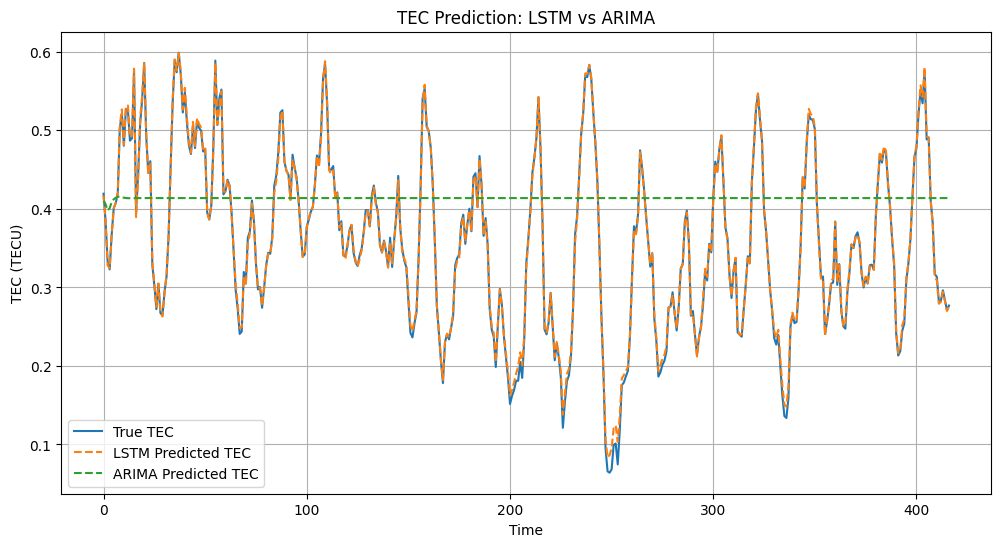

In [3]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the prepared dataset
df = pd.read_csv('prepared_tec_data.csv')

# Split data into features (X) and target (y)
target = 'TEC (TECU)'
features = ['TEC_Lag1', 'TEC_Lag2', 'TEC_Rolling_Mean', 'TEC_Rolling_Std', 'Month', 'Day', 'Weekday', 'Kp_mean', 'Sunspot', 'F107', 'Kp_F107']

X = df[features].values
y = df[target].values

# Scale features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_Y.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Train LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', input_shape=input_shape, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape data for LSTM (3D input: samples, time steps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the LSTM model
lstm_model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predict using LSTM model
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred_rescaled = scaler_Y.inverse_transform(lstm_pred)

# Evaluate LSTM model
lstm_mse = mean_squared_error(y_test, lstm_pred_rescaled)
print(f"LSTM Model Mean Squared Error: {lstm_mse}")

# ARIMA model for short-term prediction
def build_arima_model(y_train, y_test):
    # ARIMA requires univariate time series, so we will use only TEC for ARIMA
    model = sm.tsa.ARIMA(y_train, order=(5, 1, 0))  # p=5, d=1, q=0 (can be tuned)
    model_fit = model.fit()

    # Forecast
    arima_pred = model_fit.forecast(steps=len(y_test))

    # Rescale the forecasted values
    arima_pred_rescaled = scaler_Y.inverse_transform(arima_pred.reshape(-1, 1))

    return arima_pred_rescaled

# Train ARIMA model and predict
arima_pred_rescaled = build_arima_model(y_train, y_test)

# Evaluate ARIMA model
arima_mse = mean_squared_error(y_test, arima_pred_rescaled)
print(f"ARIMA Model Mean Squared Error: {arima_mse}")

# Visualizing the results
plt.figure(figsize=(12, 6))
plt.plot(scaler_Y.inverse_transform(y_test.reshape(-1, 1)), label='True TEC')
plt.plot(lstm_pred_rescaled, label='LSTM Predicted TEC', linestyle='--')
plt.plot(arima_pred_rescaled, label='ARIMA Predicted TEC', linestyle='--')
plt.xlabel('Time')
plt.ylabel('TEC (TECU)')
plt.title('TEC Prediction: LSTM vs ARIMA')
plt.legend()
plt.grid()
plt.show()







In [4]:
lstm_model.save('tec_lstm_model.h5')


In [5]:
from google.colab import files
files.download('tec_lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense

# Load the prepared dataset
df = pd.read_csv('prepared_tec_data.csv')

# Prepare data
target = 'TEC (TECU)'
features = ['TEC_Lag1', 'TEC_Lag2', 'TEC_Rolling_Mean', 'TEC_Rolling_Std', 'Month', 'Day', 'Weekday', 'Kp_mean', 'Sunspot', 'F107', 'Kp_F107']

X = df[features].values
y = df[target].values

# Scale features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_Y.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Reshape data for LSTM (3D input: samples, time steps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# If you already have a trained model, load it instead of training
try:
    lstm_model = load_model('tec_model.h5')
except:
    # Simplified LSTM model
    def build_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(units=32, activation='relu', input_shape=input_shape, return_sequences=False))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Build and train the LSTM model
    lstm_model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
    lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test))
    lstm_model.save('tec_model.h5')  # Save the trained model

# Function to predict TEC for the given date
def predict_tec(user_date):
    # Extract date information
    user_date = pd.to_datetime(user_date)
    user_month = user_date.month
    user_day = user_date.day
    user_weekday = user_date.weekday()  # Monday=0, Sunday=6

    # User input features (dummy values for simplicity, can be adjusted)
    user_features = {
        'TEC_Lag1': 10,  # Example value
        'TEC_Lag2': 12,  # Example value
        'TEC_Rolling_Mean': 11,  # Example value
        'TEC_Rolling_Std': 2,  # Example value
        'Month': user_month,
        'Day': user_day,
        'Weekday': user_weekday,
        'Kp_mean': 3,  # Example value, should be replaced with actual data
        'Sunspot': 50,  # Example value, should be replaced with actual data
        'F107': 150,  # Example value, should be replaced with actual data
        'Kp_F107': 4  # Example value, should be replaced with actual data
    }

    user_input = np.array(list(user_features.values())).reshape(1, -1)
    user_input_scaled = scaler_X.transform(user_input)

    # Predict TEC for the given date
    user_input_lstm = user_input_scaled.reshape(user_input_scaled.shape[0], 1, user_input_scaled.shape[1])
    user_pred_tec = lstm_model.predict(user_input_lstm)
    user_pred_tec_rescaled = scaler_Y.inverse_transform(user_pred_tec)

    return user_pred_tec_rescaled[0][0]

# Example user input for TEC prediction
user_date = input("Enter the date (YYYY-MM-DD): ")  # User inputs the date
predicted_tec = predict_tec(user_date)

# Output the predicted TEC value
print(f"Predicted TEC for {user_date}: {predicted_tec} TECU")



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.2616 - val_loss: 0.0125
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8895e-04 - val_loss: 0.0012
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3363e-04 - val_loss: 0.0011
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8643e-04 - val_loss: 9.1667e-04
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7673e-04 - val_loss: 7.7567e-04
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2346e-04 - val_loss: 6.3737e-04
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9503e-04 - val_loss: 6.3825e-04
Epoch 12/20
105/105 ━

Enter the date (YYYY-MM-DD): 2025-05-22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Predicted TEC for 2025-05-22: 116.93612670898438 TECU


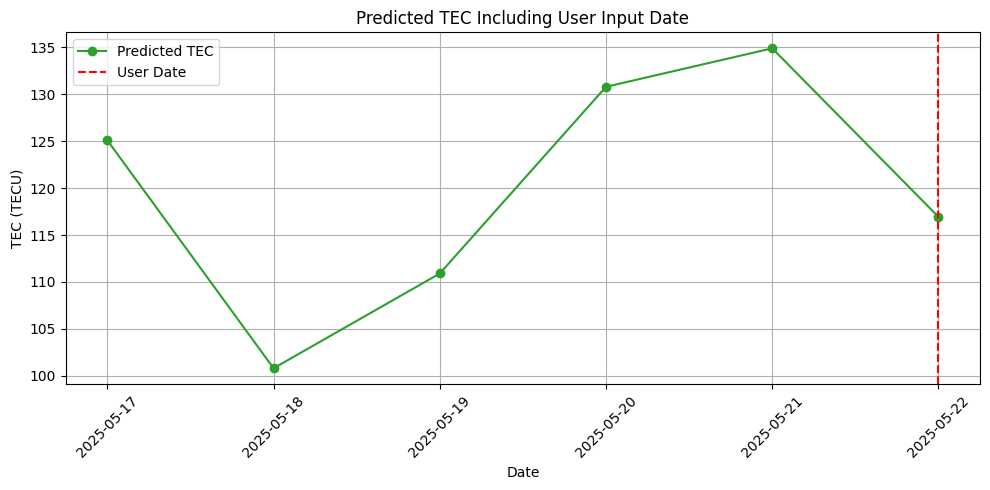

In [7]:
import matplotlib.pyplot as plt




past_predicted_tecs = [125.1, 100.8, 110.9, 130.8, 134.9]  # Example dummy predictions
dates = pd.date_range(end=pd.to_datetime(user_date), periods=6).strftime('%Y-%m-%d').tolist()
predicted_all = past_predicted_tecs + [predicted_tec]

plt.figure(figsize=(10, 5))
plt.plot(dates, predicted_all, marker='o', color='tab:green', label='Predicted TEC')
plt.axvline(x=dates[-1], color='red', linestyle='--', label='User Date')
plt.title('Predicted TEC Including User Input Date')
plt.xlabel('Date')
plt.ylabel('TEC (TECU)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17144177839750777163
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7599701493868329657
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [9]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1
